In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
#from category_encoders import TargetEncoder

In [2]:
# Load data
df = pd.read_csv("/content/data/state_level_data.csv")

In [3]:
df

,RegionName,StateName,Date,TopTier,MiddleTier,BottomTier,SingleFamily,Condo,1BHK,2BHK,...,MultifamilyRent,SingleFamilyRent,SeasonalAllHomesRent,SeasonalMultifamilyRent,SeasonalSingleFamilyRent,ZORDI,PctSoldBelowList,NewConSalePrice,NewConSalePriceSqFt,MedianListPrice
0,"Los Angeles, CA",CA,2020-06-30,1.162437e+06,692709.155101,482112.916477,722666.052404,523499.776213,445203.481299,550611.075757,...,2174.202572,3229.571802,2320.978200,2183.842961,3232.197550,134.0,0.501218,1098253.0,607.024834,819000.0
1,"Chicago, IL",IL,2020-06-30,4.229209e+05,250456.136880,149956.832438,257755.873117,206966.438442,160923.952997,180026.944146,...,1672.908263,1824.532020,1677.557975,1658.497632,1818.115553,97.0,0.697391,482860.0,181.670786,305000.0
2,"Dallas, TX",TX,2020-06-30,4.371268e+05,271809.179451,181797.447883,270853.514036,183579.390198,133926.022959,170464.587332,...,1286.185507,1751.036748,1383.192096,1283.038454,1750.281954,108.0,0.520436,341732.0,142.478673,331900.0
3,"Houston, TX",TX,2020-06-30,3.954540e+05,234440.009994,156726.798926,234904.625421,128670.425313,111340.432485,143931.616756,...,1243.348378,1708.691620,1375.329884,1247.742053,1703.780426,46.0,0.634123,303720.0,130.118343,306997.0
4,"Washington, DC",VA,2020-06-30,7.652434e+05,457671.530975,294673.564753,485376.289901,311181.199984,310598.231169,341672.342936,...,1927.924415,2476.972553,1962.207966,1922.069989,2461.170188,102.0,0.367973,558642.5,205.695398,475000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5891,"Burlington, NC",NC,2025-03-31,4.261431e+05,288087.556339,188068.687464,294439.326895,229255.599967,135550.291098,182464.372871,...,1293.038964,1740.784086,1532.685122,1289.201269,1742.359451,71.0,0.542857,387500.0,172.181351,325000.0
5892,"Coeur d'Alene, ID",ID,2025-03-31,9.745493e+05,579544.543582,439605.325510,592639.216180,444773.787424,452692.237506,465385.582532,...,1606.621672,2373.684270,1903.084635,1626.643858,2391.402830,48.0,0.563636,637450.0,285.040945,675000.0
5893,"Homosassa Springs, FL",FL,2025-03-31,4.419423e+05,278521.607429,196035.541661,286283.642360,181053.046071,144811.417838,207104.462386,...,1273.570758,1770.604870,1727.971464,1251.004036,1771.582570,33.0,0.771689,265000.0,178.448868,315450.0
5894,"New Bern, NC",NC,2025-03-31,4.019812e+05,251865.956852,135448.106946,254863.558846,237662.941327,174217.015791,164824.003477,...,1389.086809,1636.428276,1517.113848,1382.782403,1658.067864,51.0,0.602041,344275.0,157.252286,325000.0


In [4]:
abs(df.drop(columns=["RegionName", "Date", "StateName"]).corr()["AllHomesRent"]).sort_values(ascending=False).head(10)

,AllHomesRent
AllHomesRent,1.000000
SeasonalAllHomesRent,0.999183
MultifamilyRent,0.969634
SeasonalMultifamilyRent,0.968733
SingleFamilyRent,0.951945
SeasonalSingleFamilyRent,0.950538
3BHK,0.848858
MedianListPrice,0.847565
4BHK,0.843827
TopTier,0.839512


**Feature engineering**

In [5]:
# Extract seasonality information directly from the Date column.

df["Date"]   = pd.to_datetime(df["Date"])
df["Year"]   = df["Date"].dt.year
df["Month"]  = df["Date"].dt.month
df["Quarter"]= df["Date"].dt.quarter

df = df.drop(columns=["Date"])

In [6]:
if {"TopTier", "BottomTier"}.issubset(df.columns):
    df["Top_to_Bottom_Ratio"] = df["TopTier"] / (df["BottomTier"] + 1e-6)

if {"Condo", "SingleFamily"}.issubset(df.columns):
    df["Condo_to_SF_Ratio"] = df["Condo"] / (df["SingleFamily"] + 1e-6)


*  Captures price dispersion that absolute tiers alone can miss.
*  Acts as an inflation-proof, dimensionless indicator—helpful when comparing markets of different scale.
*  Gives linear models a single variable summarising the interaction between two highly correlated columns, reducing multicollinearity.
* Highlights housing-type preference in each region (urban vs. suburban bias).

In [7]:
# Log-transform skewed monetary columns except target
monetary_cols = [c for c in df.select_dtypes("number").columns
                 if ("Price" in c or "Rent" in c) and c != "AllHomesRent"]
for col in monetary_cols:
    df[f"log_{col}"] = np.log1p(df[col])

In [8]:
monetary_cols

['MultifamilyRent',
 'SingleFamilyRent',
 'SeasonalAllHomesRent',
 'SeasonalMultifamilyRent',
 'SeasonalSingleFamilyRent',
 'NewConSalePrice',
 'NewConSalePriceSqFt',
 'MedianListPrice']

In [9]:
# Automatically drop any super-correlated columns
target = "AllHomesRent"
corr_cutoff = 0.90
high_corr_cols = (
    df.drop(columns=[target, "RegionName", "StateName"])
      .corrwith(df[target])
      .abs()
      .loc[lambda s: s > corr_cutoff]
      .index
      .tolist()
)
print("Dropping highly correlated columns:", high_corr_cols)
df = df.drop(columns=high_corr_cols + ["RegionName"])

Dropping highly correlated columns: ['MultifamilyRent', 'SingleFamilyRent', 'SeasonalAllHomesRent', 'SeasonalMultifamilyRent', 'SeasonalSingleFamilyRent', 'log_MultifamilyRent', 'log_SingleFamilyRent', 'log_SeasonalAllHomesRent', 'log_SeasonalMultifamilyRent', 'log_SeasonalSingleFamilyRent']


In [10]:
# Separate target / features
y = df[target]
X = df.drop(columns=[target])

In [11]:
# Train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [12]:
# Column groups
onehot_cols   = ["StateName"]          # low-cardinality
num_cols      = X.select_dtypes("number").columns.tolist()
num_cols      = [c for c in num_cols if c not in onehot_cols]

In [13]:
# Pre-processing transformer
preprocess = ColumnTransformer(
    transformers=[
        ("ohe",    OneHotEncoder(handle_unknown="ignore"), onehot_cols),
        ("num",    StandardScaler(),                       num_cols)
    ],
    remainder="drop"
)

In [14]:
# Build full pipeline
pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("model", LinearRegression())
])

In [15]:
# Fit & evaluate
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2   = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.3f}   |   R²: {r2:.3f}")

RMSE: 100.537   |   R²: 0.945


In [16]:
# Coefficients and intercept
# Access the fitted linear regression model from the pipeline
linear_model = pipe.named_steps['model']
preprocessor = pipe.named_steps['prep']

# Get feature names after preprocessing
# This depends on the scikit-learn version. For newer versions, use get_feature_names_out()
try:
    feature_names = preprocessor.get_feature_names_out()
except AttributeError:
    # Fallback for older versions
    feature_names = []
    for name, transformer, cols in preprocessor.transformers_:
        if hasattr(transformer, 'get_feature_names_out'):
            feature_names.extend(transformer.get_feature_names_out(cols))
        else:
             # For transformers without get_feature_names_out (like StandardScaler)
             feature_names.extend(cols)


coef_series = pd.Series(linear_model.coef_, index=feature_names, name="beta")
intercept   = linear_model.intercept_

print("Intercept:", intercept)
print("\nOLS coefficients:")
print(coef_series.sort_values(key=abs, ascending=False))

Intercept: 1627.1530902095

OLS coefficients:
ohe__StateName_NY       819.544116
num__MiddleTier        -475.092174
num__3BHK               469.870586
ohe__StateName_UT      -373.252160
ohe__StateName_IL       370.048161
                           ...    
ohe__StateName_TN         6.518205
num__Quarter              2.067374
ohe__StateName_CA        -1.978896
num__ZORDI                1.494297
num__MedianListPrice      1.446618
Name: beta, Length: 61, dtype: float64


In [18]:
# Mean Rent
df[target].mean()

np.float64(1669.139661646347)



*   RMSE : 100.537

On average, the model's predictions are 100.5 dollars away from the true rent value.
Given the mean rent in the dataset is 1 671 dollars, the typical error is about 6 % of the average rent

*   R² : 0.945

The model explains 94.5 % of the variance in rent. In other words, most of the factors driving rent differences are captured by the current feature set and linear model.





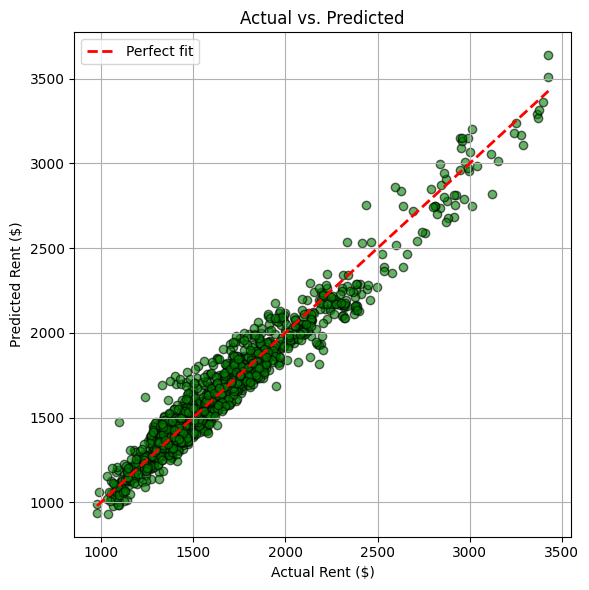

In [20]:
# Actual vs. Predicted Scatter
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolor="k", color = 'green')
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         "r--", lw=2, label="Perfect fit")
plt.xlabel("Actual Rent ($)")
plt.ylabel("Predicted Rent ($)")
plt.title("Actual vs. Predicted")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

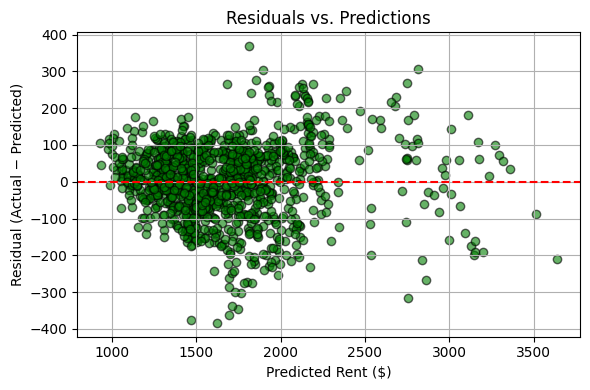

In [21]:
# Residual Plot

residuals = y_test - y_pred

plt.figure(figsize=(6, 4))
plt.scatter(y_pred, residuals, alpha=0.6, edgecolor="k", color='green')
plt.axhline(0, color="red", ls="--")
plt.xlabel("Predicted Rent ($)")
plt.ylabel("Residual (Actual − Predicted)")
plt.title("Residuals vs. Predictions")
plt.grid(True)
plt.tight_layout()
plt.show()


### **Key Observations:**


* **No big overall bias :**Dots scatter around the zero line, so the model isn’t consistently over- or under-pricing.


* **Errors grow for very cheap or very expensive rentals :**Near $1 500 a month the dots stay tight, but at higher predicted rents they spread out.
* **A slight “curve” in the cloud of points :**The model tends to undervalue the priciest homes and overvalue some mid-range homes.
* **A handful of clear outliers :**A few dots sit far from the pack. These properties behave differently from most others or could be data entry errors.




In [22]:
# Define the parameter grid for GridSearchCV
param_grid = {
    "model__alpha": [0.01, 0.05, 0.1, 0.2, 0.5, 1, 10]  # Alpha values to test
}

# Build the pipeline with Ridge regression
pipe_ridge = Pipeline(steps=[
    ("prep", preprocess),
    ("model", Ridge())
])

# Set up GridSearchCV
search = GridSearchCV(
    pipe_ridge,
    param_grid,
    cv=5,  # 5-fold cross-validation
    scoring="neg_root_mean_squared_error",  # Use negative RMSE for scoring
    return_train_score=True
)

# Fit GridSearchCV
search.fit(X_train, y_train)

print("Best parameter (alpha):", search.best_params_)
print("Best cross-validation RMSE:", -search.best_score_)

Best parameter (alpha): {'model__alpha': 0.2}
Best cross-validation RMSE: 101.20770013866085


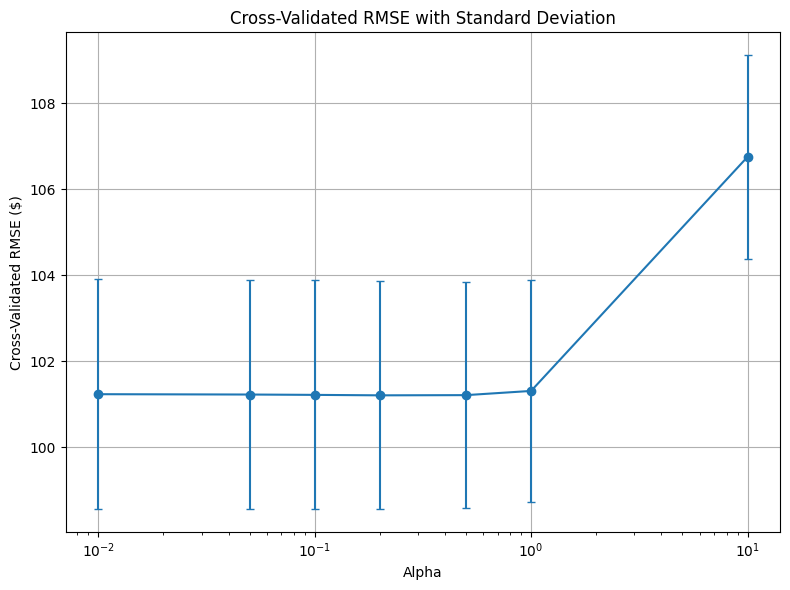

In [23]:
# Cross-Val Error Bar (Boxplot)

# Get the cross-validation results
cv_results = search.cv_results_

# Get the mean and standard deviation of test scores for each alpha
mean_scores = cv_results["mean_test_score"]
std_scores = cv_results["std_test_score"]
alpha_values = cv_results["param_model__alpha"]

plt.figure(figsize=(8, 6))
plt.errorbar(alpha_values, -mean_scores, yerr=std_scores, fmt='o-', capsize=3)
plt.xscale('log')
plt.xlabel("Alpha")
plt.ylabel("Cross-Validated RMSE ($)")
plt.title("Cross-Validated RMSE with Standard Deviation")
plt.grid(True)
plt.tight_layout()
plt.show()

### **Key Observations:**
**Flat bottom around α = 0.01 – 0.2**

* RMSE hovers at ≈ $100 with very little variance.

* These tiny penalties neither help nor hurt—OLS already fits well.

**Performance worsens when α jumps to 1 and 10**

* At α = 10, CV-RMSE climbs to ≈ $106–108.

* Heavy shrinkage forces important coefficients toward zero, adding bias.

**Error bars overlap at small α**

* Differences among α = 0.01, 0.05, 0.1, 0.2 are within the fold-to-fold noise (~$2).

* Confirms no meaningful gain from regularisation.